In [1]:
import pandas as pd
from utilities import *

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Data Import and Preparation

In [2]:
df = pd.read_excel(r'https://archive.ics.uci.edu/ml/machine-learning-databases/00193/CTG.xls', sheet_name='Data', skiprows=1)
df.describe()

,b,e,AC,FM,UC,DL,DS,DP,DR,Unnamed: 9,...,E,AD,DE,LD,FS,SUSP,Unnamed: 42,CLASS,Unnamed: 44,NSP
count,2126.000000,2126.000000,2126.000000,2127.000000,2127.000000,2128.000000,2128.000000,2128.000000,2128.0,0.0,...,2127.000000,2127.000000,2127.000000,2127.000000,2127.000000,2127.000000,0.0,2126.000000,0.0,2126.000000
mean,878.439793,1702.877234,2.722484,7.503056,3.669017,1.576128,0.003759,0.127820,0.0,NaN,...,-0.897978,-0.531265,-0.644100,-0.848613,-0.902210,-0.721674,NaN,4.509878,NaN,1.304327
std,894.084748,930.919143,3.560850,39.030452,2.877148,2.517794,0.061213,0.471687,0.0,NaN,...,1.622232,7.250058,5.518616,2.380073,1.557258,4.328211,NaN,3.026883,NaN,0.614377
min,0.000000,287.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,1.000000,NaN,1.000000
25%,55.000000,1009.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,NaN,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,2.000000,NaN,1.000000
50%,538.000000,1241.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.0,NaN,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,4.000000,NaN,1.000000
75%,1521.000000,2434.750000,4.000000,2.000000,5.000000,3.000000,0.000000,0.000000,0.0,NaN,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,7.000000,NaN,1.000000
max,3296.000000,3599.000000,26.000000,564.000000,23.000000,16.000000,1.000000,4.000000,0.0,NaN,...,72.000000,332.000000,252.000000,107.000000,69.000000,197.000000,NaN,10.000000,NaN,3.000000


In [3]:
# If ALL values are null, drop the column
df = df.dropna(axis=1, how='all')
# If ANY values are null, drop the row
df = df.dropna(axis=0, how='any')
# No relevant information in these columns (b: start, e: end, DR: column data removed)
df = df.drop(['b','e','DR'], axis=1)
# CLASS code (1 to 10) is already summarised by categorical variables
df = df.drop(['CLASS'], axis=1)
df[['A','B','C','D','E','AD','DE','LD','FS','SUSP']] = np.where(df[['A','B','C','D','E','AD','DE','LD','FS','SUSP']] == -1,
                                                                0,
                                                                1)
df[['A','B','C','D','E','AD','DE','LD','FS','SUSP']] = df[['A','B','C','D','E','AD','DE','LD','FS','SUSP']].astype('object')
df.describe()

,AC,FM,UC,DL,DS,DP,LB,AC.1,FM.1,UC.1,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,2.722484,7.241298,3.659925,1.570085,0.003293,0.126058,133.303857,0.003170,0.009474,0.004357,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,3.560850,37.125309,2.847094,2.499229,0.057300,0.464361,9.840844,0.003860,0.046670,0.002940,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106.000000,0.000000,0.000000,0.000000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,0.001876,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,133.000000,0.001630,0.000000,0.004482,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,4.000000,2.000000,5.000000,3.000000,0.000000,0.000000,140.000000,0.005631,0.002512,0.006525,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,26.000000,564.000000,23.000000,16.000000,1.000000,4.000000,160.000000,0.019284,0.480634,0.014925,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


# Exploratory Data Analysis

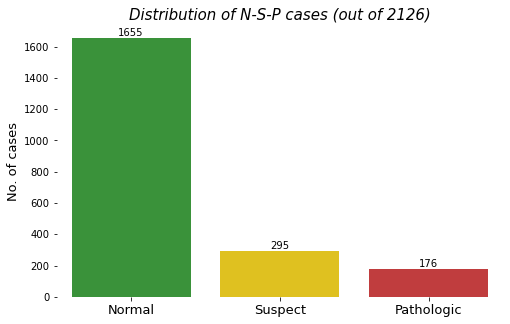

In [4]:
plot_distribution(df, figsize=(8,5), save_fig=True)

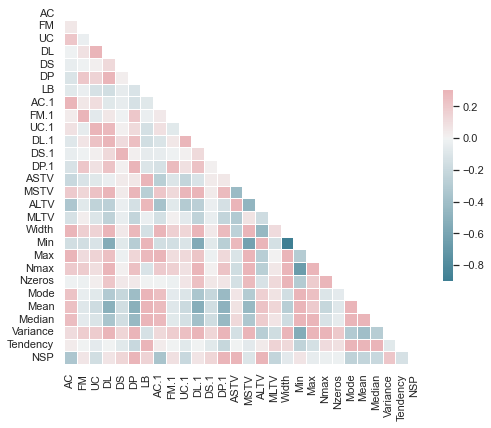

In [5]:
plot_correlation_matrix(df, figsize=(8,7), save_fig=True)

# ML classification

In [6]:
X, Y = df.iloc[:,:-1], df.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

numerical_cols_selector = make_column_selector(dtype_exclude=object)
numerical_cols = numerical_cols_selector(X)
numerical_preproc = StandardScaler()
preprocessor = ColumnTransformer([('standard_scaler', numerical_preproc, numerical_cols)])

## 1. Logistic Regression

In [7]:
log_pipe = make_pipeline(#SMOTE(random_state = 42),
                         #preprocessor,
                         StandardScaler(),
                         LogisticRegression(class_weight = 'balanced', random_state = 42))

log_params = {'logisticregression__multi_class': ('ovr', 'multinomial'),
              'logisticregression__solver': ('newton-cg', 'lbfgs', 'saga')}
log_grid_search = GridSearchCV(log_pipe, param_grid = log_params,
                               scoring = 'f1_weighted', n_jobs = -1, cv = 5, refit = True)
log_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__multi_class': ('ovr',
                                                             'multinomial'),
                         'logisticregression__solver': ('newton-cg', 'lbfgs',
                                                        'saga')},
             scoring='f1_weighted')

In [8]:
print(f'Best Parameters: {log_grid_search.best_params_}')
log_best_pipe = log_grid_search.best_estimator_
log_prediction = log_best_pipe.predict(X_test)

Best Parameters: {'logisticregression__multi_class': 'ovr', 'logisticregression__solver': 'lbfgs'}


In [9]:
print(classification_report(Y_test, log_prediction))

              precision    recall  f1-score   support

         1.0       0.99      0.98      0.98       333
         2.0       0.87      0.95      0.91        64
         3.0       1.00      0.97      0.98        29

    accuracy                           0.97       426
   macro avg       0.95      0.96      0.96       426
weighted avg       0.97      0.97      0.97       426



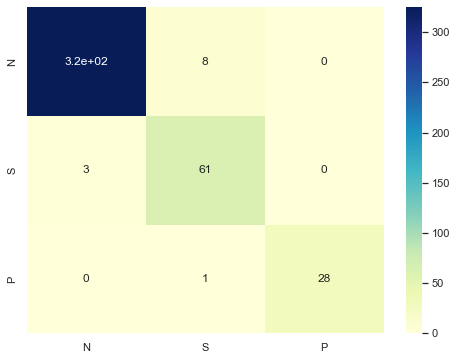

In [10]:
plot_confusion_matrix(Y_test, log_prediction)

## 2. SVM

In [11]:
svm_pipe = make_pipeline(SMOTE(random_state = 42),
                         #preprocessor,
                         StandardScaler(),
                         SVC(kernel='rbf', random_state = 42))

svm_params = {'svc__C': (1e2, 1e3, 1e4),
              'svc__gamma': (1e-7, 1e-6, 1e-5)}
svm_grid_search = GridSearchCV(svm_pipe, param_grid = svm_params,
                               scoring = 'f1_weighted', n_jobs = -1, cv = 5, refit = True)
svm_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('standardscaler', StandardScaler()),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svc__C': (100.0, 1000.0, 10000.0),
                         'svc__gamma': (1e-07, 1e-06, 1e-05)},
             scoring='f1_weighted')

In [12]:
print(f'Best Parameters: {svm_grid_search.best_params_}')
svc_best_pipe = svm_grid_search.best_estimator_
svm_prediction = svc_best_pipe.predict(X_test)

Best Parameters: {'svc__C': 1000.0, 'svc__gamma': 1e-05}


In [13]:
print(classification_report(Y_test, svm_prediction))

              precision    recall  f1-score   support

         1.0       0.99      0.98      0.99       333
         2.0       0.90      0.95      0.92        64
         3.0       1.00      0.97      0.98        29

    accuracy                           0.98       426
   macro avg       0.96      0.97      0.96       426
weighted avg       0.98      0.98      0.98       426



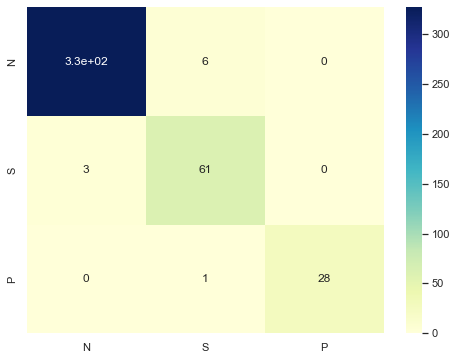

In [14]:
plot_confusion_matrix(Y_test, svm_prediction)

## 3. k-NN

In [15]:
knn_pipe = make_pipeline(SMOTE(random_state = 42),
                         #preprocessor,
                         StandardScaler(),
                         KNeighborsClassifier())

knn_params = {'kneighborsclassifier__n_neighbors': (1, 2, 3, 4, 5),
              'kneighborsclassifier__weights': ('uniform', 'distance')}
knn_grid_search = GridSearchCV(knn_pipe, param_grid = knn_params,
                               scoring = 'f1_weighted', n_jobs = -1, cv = 5, refit = True)
knn_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': (1, 2, 3, 4, 5),
                         'kneighborsclassifier__weights': ('uniform',
                                                           'distance')},
             scoring='f1_weighted')

In [16]:
print(f'Best Parameters: {knn_grid_search.best_params_}')
knn_best_pipe = knn_grid_search.best_estimator_
knn_prediction = knn_best_pipe.predict(X_test)

Best Parameters: {'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__weights': 'uniform'}


In [17]:
print(classification_report(Y_test, knn_prediction))

              precision    recall  f1-score   support

         1.0       0.99      0.98      0.99       333
         2.0       0.91      0.95      0.93        64
         3.0       1.00      0.97      0.98        29

    accuracy                           0.98       426
   macro avg       0.97      0.97      0.97       426
weighted avg       0.98      0.98      0.98       426



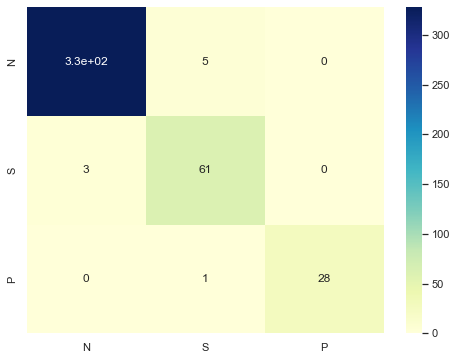

In [18]:
plot_confusion_matrix(Y_test, knn_prediction)

## 4. Trees

### 4.1 Decision Tree

In [19]:
tree_pipe = make_pipeline(SMOTE(random_state = 42),
                          #StandardScaler()
                          DecisionTreeClassifier(class_weight = 'balanced', random_state = 42))

tree_params = {'decisiontreeclassifier__criterion': ('gini', 'entropy', 'log_loss'),
               'decisiontreeclassifier__max_depth': (5, 10, None)}
tree_grid_search = GridSearchCV(tree_pipe, param_grid = tree_params,
                                scoring = 'f1_weighted', n_jobs = -1, cv = 5, refit = True)
tree_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ('gini',
                                                               'entropy',
                                                               'log_loss'),
                         'decisiontreeclassifier__max_depth': (5, 10, None)},
             scoring='f1_weighted')

In [20]:
print(f'Best Parameters: {tree_grid_search.best_params_}')
tree_best_pipe = tree_grid_search.best_estimator_
tree_prediction = tree_best_pipe.predict(X_test)

Best Parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': None}


In [21]:
print(classification_report(Y_test, tree_prediction))

              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       333
         2.0       0.95      0.94      0.94        64
         3.0       1.00      0.97      0.98        29

    accuracy                           0.98       426
   macro avg       0.98      0.97      0.97       426
weighted avg       0.98      0.98      0.98       426



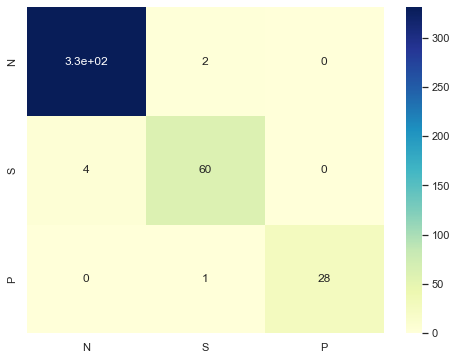

In [22]:
plot_confusion_matrix(Y_test, tree_prediction)

In [23]:
print('Feature importance\n')
for importance, name in sorted(zip(tree_grid_search.best_estimator_.named_steps['decisiontreeclassifier'].feature_importances_,
                                   df.columns),
                               reverse = True)[:8]:
    print (f'{name}:\t {round(importance, 2)}')

Feature importance

SUSP:	 0.34
FS:	 0.25
LD:	 0.22
E:	 0.11
DE:	 0.04
Max:	 0.02
ASTV:	 0.01
DP:	 0.0


### 4.2 Random Forest

In [24]:
forest_pipe = make_pipeline(SMOTE(random_state = 42),
                            #StandardScaler(),
                            RandomForestClassifier(class_weight = 'balanced', random_state = 42))

forest_params = {'randomforestclassifier__n_estimators': (10, 25, 50, 75, 100),
                 'randomforestclassifier__criterion': ('gini', 'entropy', 'log_loss'),
                 'randomforestclassifier__max_depth': (5, 10, None),
                 'randomforestclassifier__bootstrap': (True, False)}
forest_grid_search = GridSearchCV(forest_pipe, param_grid = forest_params,
                                  scoring = 'f1_weighted', n_jobs = -1, cv = 5, refit = True)
forest_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__bootstrap': (True, False),
                         'randomforestclassifier__criterion': ('gini',
                                                               'entropy',
                                                               'log_loss'),
                         'randomforestclassifier__max_depth': (5, 10, None),
                         'randomforestclassifier__n_estimators': (10, 25, 50,
                                                                  75, 100)},
             scoring='f1_weighted')

In [25]:
print(f'Best Parameters: {forest_grid_search.best_params_}')
forest_best_pipe = forest_grid_search.best_estimator_
forest_prediction = forest_best_pipe.predict(X_test)

Best Parameters: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 25}


In [26]:
print(classification_report(Y_test, forest_prediction))

              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       333
         2.0       0.95      0.95      0.95        64
         3.0       1.00      0.97      0.98        29

    accuracy                           0.99       426
   macro avg       0.98      0.97      0.98       426
weighted avg       0.99      0.99      0.99       426



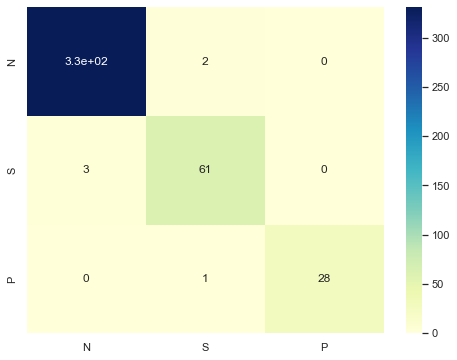

In [27]:
plot_confusion_matrix(Y_test, forest_prediction, save_fig=True)

In [28]:
print('Feature importance\n')
for importance, name in sorted(zip(forest_grid_search.best_estimator_.named_steps['randomforestclassifier'].feature_importances_,
                                   df.columns),
                               reverse = True)[:8]:
    print (f'{name}:\t {round(importance, 2)}')

Feature importance

LD:	 0.13
SUSP:	 0.13
FS:	 0.09
Median:	 0.07
MSTV:	 0.06
ALTV:	 0.06
DP:	 0.04
ASTV:	 0.04


In [29]:
result = permutation_importance(forest_grid_search.best_estimator_.named_steps['randomforestclassifier'],
                                X_test, Y_test, n_repeats = 5, random_state = 42, n_jobs = -1)

forest_importances = pd.Series(result.importances_mean, index = df.columns[:-1]).sort_values(ascending=False)

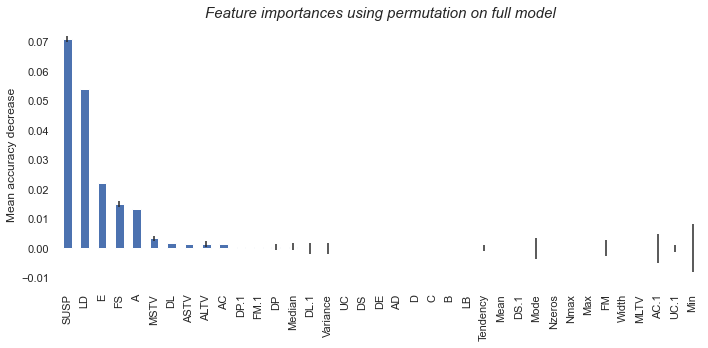

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title('Feature importances using permutation on full model',
             fontsize=15, style='italic')
ax.set_ylabel('Mean accuracy decrease', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.tight_layout()
plt.savefig('feature_importance.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## 5. Stacking Random Forest and SVM

In [31]:
stacked_estimators = [('rf', make_pipeline(SMOTE(random_state = 42),
                                           RandomForestClassifier(random_state = 42, bootstrap = True,
                                                                  criterion = 'gini', n_estimators = 25))),
                      ('svc', make_pipeline(SMOTE(random_state = 42),
                                            StandardScaler(),
                                            SVC(random_state=42, C = 1e3, gamma = 1e-05)))]

clf = StackingClassifier(estimators = stacked_estimators, final_estimator = LogisticRegression(random_state = 42))
clf.fit(X_train, Y_train)

stack_prediction = clf.predict(X_test)

In [32]:
print(classification_report(Y_test, stack_prediction))

              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       333
         2.0       0.94      0.95      0.95        64
         3.0       1.00      0.97      0.98        29

    accuracy                           0.98       426
   macro avg       0.98      0.97      0.97       426
weighted avg       0.98      0.98      0.98       426



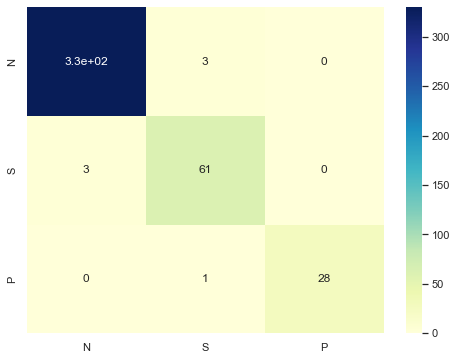

In [33]:
plot_confusion_matrix(Y_test, stack_prediction)

## 6. Extra -- ANN (*no fine tuning, just for curiosity*)

In [34]:
X, Y = df.iloc[:,:-1].values, df.iloc[:, -1].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [35]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

ohe = OneHotEncoder()
Y_train_ann = ohe.fit_transform(Y_train.reshape(-1, 1)).toarray()
Y_train_ann = np.delete(Y_train_ann, 1, 1) # Delete a redundant column got after OHE

# Initializing the ANN
clf = Sequential()

# Input layer and 1st hidden layer
clf.add(Dense(units = 20, activation = 'relu', input_dim = 37))

# 2nd hidden layer
clf.add(Dense(units = 20, activation = 'relu'))

# Output layer
clf.add(Dense(units = 2, activation = 'sigmoid'))

metrics = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'), 
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]
clf.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = metrics)

clf.fit(np.asarray(X_train).astype('float32'), np.asarray(Y_train_ann).astype('float32'),
        batch_size = 200, epochs = 20)

Epoch 1/20
9/9 [==============================] - 0s 3ms/step - loss: 12.4182 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1931.0000 - fn: 1469.0000 - accuracy: 0.5679 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5003
Epoch 2/20
9/9 [==============================] - 0s 3ms/step - loss: 4.2993 - tp: 0.0000e+00 - fp: 3.0000 - tn: 1928.0000 - fn: 1469.0000 - accuracy: 0.5671 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4990
Epoch 3/20
9/9 [==============================] - 0s 3ms/step - loss: 1.3541 - tp: 2.0000 - fp: 10.0000 - tn: 1921.0000 - fn: 1467.0000 - accuracy: 0.5656 - precision: 0.1667 - recall: 0.0014 - auc: 0.4961     
Epoch 4/20
9/9 [==============================] - 0s 3ms/step - loss: 1.3930 - tp: 2.0000 - fp: 18.0000 - tn: 1913.0000 - fn: 1467.0000 - accuracy: 0.5632 - precision: 0.1000 - recall: 0.0014 - auc: 0.4955     
Epoch 5/20
9/9 [==============================] - 0s 3ms/step - loss: 1.3937 - tp: 6.0000 - fp: 20.0000 - tn: 1911.0000 - fn: 1463.0000 - a

# Data reduction

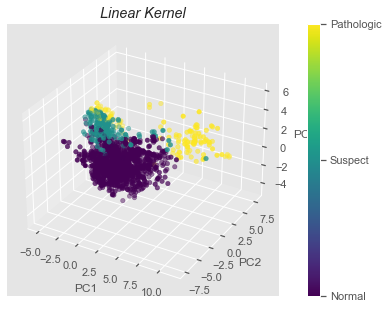

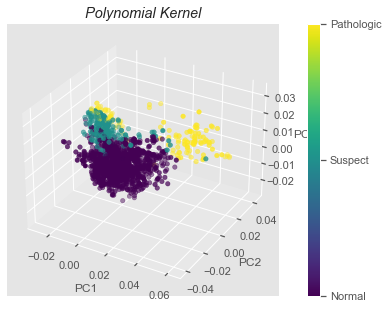

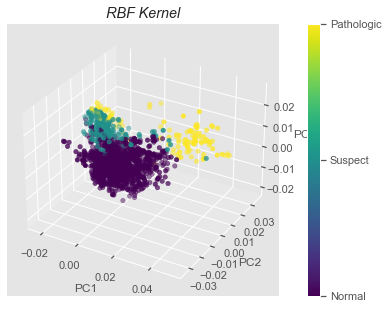

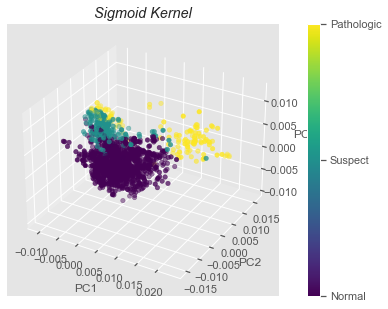

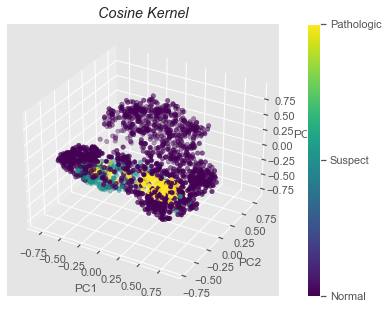

In [36]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)

names = ['Linear Kernel', 'Polynomial Kernel', 'RBF Kernel', 'Sigmoid Kernel', 'Cosine Kernel']
classifiers = [KernelPCA(n_components = 3, kernel = 'linear'),
               KernelPCA(n_components = 3, kernel = 'poly', gamma= 0.00001),
               KernelPCA(n_components = 3, kernel = 'rbf', gamma= 0.00001),
               KernelPCA(n_components = 3, kernel = 'sigmoid', gamma= 0.00001),
               KernelPCA(n_components = 3, kernel = 'cosine')]

plot_PCA(X_train_sc, Y_train, classifiers, names)